<a href="https://colab.research.google.com/github/mushamvineeth/Vineeth_INFO5731_Spring2021/blob/main/In_class_exercise_07_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)


In [ ]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
# Write your code here
import nltk
nltk.download('stopwords')

import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
!pip install pyLDAvis

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
df = pd.read_csv('data science_titles.csv', encoding = "ISO-8859-1")
df.head()

# Convert to list
data = df['Article Title'].tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

#Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

# Creating Bigram and Trigram Models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



#Remove Stopwords, Make Bigrams and Lemmatize

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

#Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

['Data science in action']
[['data', 'science', 'in', 'action']]
['data', 'science', 'in', 'action']
[['datum', 'science', 'action']]
[[(0, 1), (1, 1), (2, 1)]]


[[('action', 1), ('datum', 1), ('science', 1)]]

In [ ]:
# Building the Topic Model

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#View the topics in LDA model

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

#Compute Model Perplexity and Coherence Score

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#Visualize the topics-keywords

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.276*"science" + 0.276*"datum" + 0.146*"application" + 0.146*"transport" + '
  '0.131*"prediction" + 0.001*"probability" + 0.001*"biological" + '
  '0.001*"high" + 0.001*"quantified" + 0.001*"self"'),
 (1,
  '0.057*"datum" + 0.050*"science" + 0.032*"action" + 0.028*"revolution" + '
  '0.028*"quantified" + 0.028*"biological" + 0.028*"fundamental" + '
  '0.028*"supply" + 0.028*"discovery" + 0.028*"chain"'),
 (2,
  '0.059*"science" + 0.055*"datum" + 0.047*"action" + 0.026*"self" + '
  '0.026*"fundamental" + 0.026*"biological" + 0.026*"discovery" + '
  '0.026*"transport" + 0.026*"quantified" + 0.026*"prediction"'),
 (3,
  '0.109*"transform" + 0.109*"analytic" + 0.109*"design" + 0.109*"management" '
  '+ 0.109*"predictive" + 0.109*"revolution" + 0.109*"supply" + 0.109*"chain" '
  '+ 0.109*"datum" + 0.001*"journalism"'),
 (4,
  '0.068*"datum" + 0.056*"science" + 0.035*"nee" + 0.035*"mining" + '
  '0.035*"thinking" + 0.035*"know" + 0.035*"analytic" + 0.035*"business" + '
  '0.030*"ap

TypeError: ignored

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
8      0.187553+0.000000j -0.108086+0.000000j       1        1  17.813210
17     0.114294+0.000000j -0.136660+0.000000j       2        1  16.289311
13     0.166410+0.000000j -0.027467+0.000000j       3        1  12.489454
3     -0.165249+0.000000j -0.245397+0.000000j       4        1  11.508102
0      0.278879+0.000000j -0.034429+0.000000j       5        1  11.285838
10    -0.005096+0.000000j  0.304469+0.000000j       6        1  10.648465
6      0.106107+0.000000j  0.251543+0.000000j       7        1   6.953839
9      0.300845+0.000000j -0.033359+0.000000j       8        1   6.542908
16     0.036176+0.000000j -0.015445+0.000000j       9        1   1.313301
19    -0.047146+0.000000j  0.022331+0.000000j      10        1   0.504172
1     -0.084036+0.000000j -0.006414+0.000000j      11        1   0.488810
4     -

In [ ]:
!wget "http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip"
!unzip "/content/mallet-2.0.8.zip"

--2021-03-20 04:37:17--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.3’

mallet-2.0.8.zip.3  100%[===================>]  15.43M  5.63MB/s    in 2.7s    

2021-03-20 04:37:20 (5.63 MB/s) - ‘mallet-2.0.8.zip.3’ saved [16184794/16184794]

Archive:  /content/mallet-2.0.8.zip
replace mallet-2.0.8/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/.DS_Store  
  inflating: __MACOSX/mallet-2.0.8/._.DS_Store  
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: __MACOSX/mallet-2.0.8/bin/._classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: __MACOSX/mallet-2.0.8/bin/._csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: __MACOSX/mallet-2.0.8/b

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)



[(5,
  [('application', 0.9523809523809523),
   ('introduction', 0.047619047619047616),
   ('extensible', 0.0),
   ('use', 0.0),
   ('management', 0.0),
   ('predictive', 0.0),
   ('revolution', 0.0),
   ('supply', 0.0),
   ('transform', 0.0),
   ('chain', 0.0)]),
 (10,
  [('big', 0.4782608695652174),
   ('relationship', 0.4782608695652174),
   ('data', 0.043478260869565216),
   ('supply', 0.0),
   ('predictive', 0.0),
   ('transform', 0.0),
   ('scalable', 0.0),
   ('discovery', 0.0),
   ('revolution', 0.0),
   ('management', 0.0)]),
 (13,
  [('high', 0.2631578947368421),
   ('dimensional', 0.2631578947368421),
   ('introduction', 0.23684210526315788),
   ('probability', 0.23684210526315788),
   ('extensible', 0.0),
   ('use', 0.0),
   ('predictive', 0.0),
   ('revolution', 0.0),
   ('supply', 0.0),
   ('transform', 0.0)]),
 (19,
  [('mining', 0.3333333333333333),
   ('business', 0.3333333333333333),
   ('thinking', 0.26666666666666666),
   ('prediction', 0.06666666666666667),
   ('pr

In [ ]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

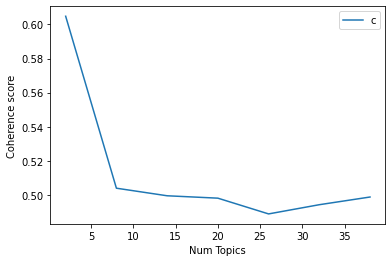

Num Topics = 2  has Coherence Value of 0.6048
Num Topics = 8  has Coherence Value of 0.5039
Num Topics = 14  has Coherence Value of 0.4995
Num Topics = 20  has Coherence Value of 0.4981
Num Topics = 26  has Coherence Value of 0.4888
Num Topics = 32  has Coherence Value of 0.4942
Num Topics = 38  has Coherence Value of 0.4987
[(0,
  '0.667*"application" + 0.333*"transport" + 0.000*"extensible" + '
  '0.000*"design" + 0.000*"management" + 0.000*"predictive" + '
  '0.000*"revolution" + 0.000*"supply" + 0.000*"transform" + 0.000*"use"'),
 (1,
  '0.526*"probability" + 0.474*"high" + 0.000*"use" + 0.000*"management" + '
  '0.000*"predictive" + 0.000*"revolution" + 0.000*"supply" + '
  '0.000*"transform" + 0.000*"extensible" + 0.000*"chain"'),
 (2,
  '0.545*"datum" + 0.364*"prediction" + 0.045*"scalable" + 0.045*"extensible" '
  '+ 0.000*"design" + 0.000*"management" + 0.000*"predictive" + '
  '0.000*"revolution" + 0.000*"supply" + 0.000*"transform"'),
 (3,
  '0.565*"action" + 0.435*"discover

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


In [ ]:
#Finding dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.0660,"action, discovery, extensible, use, design, ma...",Data science in action
1,1,2.0,0.0618,"datum, prediction, scalable, extensible, desig...",Data science and prediction
2,2,10.0,0.0876,"decision, relationship, big, transform, extens...",Data science and its relationship to big data ...
3,3,19.0,0.1082,"thinking, nee, mining, business, scalable, pre...",[BOOK][B] Data Science for Business: What you ...
4,4,1.0,0.0789,"probability, high, use, management, predictive...",[BOOK][B] High-dimensional probability: An int...
5,5,0.0,0.0833,"application, transport, extensible, design, ma...",Computational optimal transport: With applicat...
6,6,13.0,0.1365,"chain, design, supply, transform, revolution, ...","Data science, predictive analytics, and big da..."
7,7,2.0,0.0813,"datum, prediction, scalable, extensible, desig...","Reproducible, interactive, scalable and extens..."
8,8,18.0,0.0960,"quantified, biological, fundamental, transform...",The quantified self: Fundamental disruption in...
9,9,16.0,0.0998,"journalism, data, put, big, supply, management...",Putting the data science into journalism


In [ ]:
#Most Representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0833,"application, transport, extensible, design, ma...",Computational optimal transport: With applicat...
1,1.0,0.0789,"probability, high, use, management, predictive...",[BOOK][B] High-dimensional probability: An int...
2,2.0,0.0813,"datum, prediction, scalable, extensible, desig...","Reproducible, interactive, scalable and extens..."
3,3.0,0.0660,"action, discovery, extensible, use, design, ma...",Data science in action
4,9.0,0.0809,"introduction, dimensional, extensible, use, ma...",[BOOK][B] High-dimensional probability: An int...


In [ ]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"action, discovery, extensible, use, design, ma...",10.0,0.1099
1.0,2.0,"datum, prediction, scalable, extensible, desig...",9.0,0.0989
2.0,10.0,"decision, relationship, big, transform, extens...",10.0,0.1099
3.0,19.0,"thinking, nee, mining, business, scalable, pre...",13.0,0.1429
4.0,1.0,"probability, high, use, management, predictive...",NaN,NaN
...,...,...,...,...
86.0,1.0,"probability, high, use, management, predictive...",NaN,NaN
87.0,0.0,"application, transport, extensible, design, ma...",NaN,NaN
88.0,13.0,"chain, design, supply, transform, revolution, ...",NaN,NaN
89.0,18.0,"quantified, biological, fundamental, transform...",NaN,NaN


## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
# Write your code here

#Importing required Library
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

#Loading Data
def load_data(path,file_name):
    
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

#preprocessing of Data

def preprocess_data(doc_set):
    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
  
#Preparing Corpus

def prepare_corpus(doc_clean):
    
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

#Creating LSA model
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

#
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

number_of_topics=7
words=10
document_list,titles=load_data("","/content/sample_data/DataScience_Titles.txt")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)



Total Number of Documents: 92
[(0, '0.802*"data" + 0.420*"scienc" + 0.166*"big" + 0.127*"analyt" + 0.124*"book" + 0.124*"b" + 0.085*"make" + 0.085*"decis" + 0.085*"relationship" + 0.085*"driven"'), (1, '-0.375*"big" + 0.351*"book" + 0.351*"b" + 0.192*"applic" + 0.179*"mine" + 0.179*"busi" + 0.179*"need" + 0.179*"think" + 0.179*"know" + 0.173*"introduct"'), (2, '0.357*"applic" + 0.333*"scienc" + 0.230*"probabl" + 0.230*"dimension" + 0.230*"high" + 0.230*"introduct" + -0.213*"analyt" + 0.199*"disrupt" + 0.199*"fundament" + 0.199*"self"'), (3, '0.258*"self" + 0.258*"discoveri" + 0.258*"disrupt" + 0.258*"fundament" + 0.258*"quantifi" + 0.258*"biolog" + 0.220*"analyt" + -0.217*"make" + -0.217*"driven" + -0.217*"relationship"'), (4, '-0.363*"predict" + -0.300*"chain" + -0.300*"design" + -0.300*"manag" + -0.300*"revolut" + -0.300*"suppli" + -0.300*"transform" + -0.221*"analyt" + 0.193*"make" + 0.193*"driven"'), (5, '-0.346*"comput" + -0.346*"transport" + -0.346*"optim" + 0.252*"high" + 0.252*

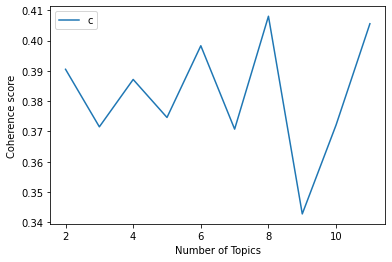

In [ ]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)

LDA has 19 point models, while LSA has two theme models; nonetheless, although the number of words in both models is the same, LSA has fewer measurements than LDA. LSA is faster than LDA because it only has two topic models. Even though the yields of both models are similar, both have to preprocess steps to lemmatize the sentences and LDA is performed using the directive-following LDA.
